In [1]:
import healpy as h
from mypymodules import fit_pl_spectra_v3 as fit_pl_spectra
from mypymodules.return_mask import gen_mask as rdm
from mypymodules import gen_mask as gm


ext=".jpg"

%pylab notebook

In [2]:
lmin=60 ; lmax=600 ; masklmax=256 ; deltaell=40 ; nsidein=512

maskdata=True ; makeplots=True ; plotmask=False
plotfit=True ; plotthry=True ; plotcmb=True ; plot_unbinned=False

nsideout=8 ; wband=15 ; discsize=11.3 ; apow=2

result_path="./results/disc_analysis/"
! mkdir $result_path
result_path=result_path + "/gal80/"
! mkdir $result_path

datatype="obs"
result_path = result_path + datatype + "/"
! mkdir $result_path

result_path= result_path + "/nside" + str(nsideout)  + "_lmin" + str(lmin) + "_lmax" + str(lmax) + "_dl" + str(deltaell) 
result_path= result_path + "_mlmax" + str(masklmax) + "_discsize" + str(discsize) + "_apow" + str(apow) + "/"
! mkdir $result_path

spectra_path = result_path + "/spectra_path/"
! mkdir $spectra_path

plot_mask_path = result_path + "/plot_mask/"
! mkdir $plot_mask_path

plot_results_path = result_path + "/results/"
! mkdir $plot_results_path

mkdir: ./results/disc_analysis/: File exists
mkdir: ./results/disc_analysis//gal80/: File exists
mkdir: ./results/disc_analysis//gal80/obs/: File exists
mkdir: ./results/disc_analysis//gal80/obs//nside8_lmin60_lmax600_dl40_mlmax256_discsize11.3_apow2/: File exists
mkdir: ./results/disc_analysis//gal80/obs//nside8_lmin60_lmax600_dl40_mlmax256_discsize11.3_apow2//spectra_path/: File exists
mkdir: ./results/disc_analysis//gal80/obs//nside8_lmin60_lmax600_dl40_mlmax256_discsize11.3_apow2//plot_mask/: File exists
mkdir: ./results/disc_analysis//gal80/obs//nside8_lmin60_lmax600_dl40_mlmax256_discsize11.3_apow2//results/: File exists


In [3]:
clthry=h.read_cl("../datain/spectra/dust_power_spectrum_gal70.fits")[1:3]
#clcmb=h.read_cl("../datain/spectra/planck_wp_highL_lensing_param.fits")[1:3]
clcmbee=h.read_cl("../datain/spectra/planck_wp_highL_lensing_param.fits")[1]
clcmbbb=h.read_cl("../datain/spectra/planck_wp_highL_lensing_param.fits")[2]
clcmbte=h.read_cl("../datain/spectra/planck_wp_highL_lensing_param.fits")[3]

if datatype=="cmbsim" or datatype=="fscmbsim":
    #clcmb=h.read_cl("../datain/spectra/cl_r00p5.fits")[1:3]
    clcmbee=h.read_cl("../datain/spectra/cl_r00p5.fits")[1]
    clcmbbb=h.read_cl("../datain/spectra/cl_r00p5.fits")[2]
    clcmbte=h.read_cl("../datain/spectra/cl_r00p5.fits")[3]
    
    
bl=h.read_cl("../datain/spectra/353_TEB_beam.fits")[1]
pwc=h.pixwin(nsidein)
blpwc=bl[:lmax+1]*pwc[:lmax+1]

if datatype=="khsim" or datatype=="cmbsim" or datatype=="fscmbsim" or datatype=="nonoise_sim" or datatype=="fsnonoise_sim" or datatype=="fskhsim":
    subtract_fiducial=False
    
if datatype=="khsim" or datatype=="cmbsim" or datatype=="fscmbsim" or datatype=="fskhsim":
    blpwc[:]=1.
    
globalmask=h.read_map("../datain/maps/mask/mask_gal80_nside" + str(nsidein) + ".fits",verbose=False) ; globalmask=globalmask*globalmask
#mask=h.read_map("../datain/maps/mask/mask_gal70_nside" + str(nsidein) + ".fits",verbose=False) ; mask=mask*mask
# Here I am squaring the mask because the Q/U to E/B pipiline returns the (mask squared)*E/B maps. This is done in this
# manner so as to ensure that we never have to take derivative of the unmasked polarization field.

In [4]:
i353=h.read_map("../../planck_data/COM_CompMap_dust-commrul_0256_R1.00.fits",verbose=False)
i353nside=h.get_nside(i353)

if datatype=="obs":
    subtract_fiducial=True
    t=h.read_map("../datain/maps/obsTEB/planck353_TEB_map_full_gal80_nside512.fits",0,verbose=False)
    e=h.read_map("../datain/maps/obsTEB/planck353_TEB_map_full_gal80_nside512.fits",1,verbose=False)
    b=h.read_map("../datain/maps/obsTEB/planck353_TEB_map_full_gal80_nside512.fits",2,verbose=False)
    e1=h.read_map("../datain/maps/obsTEB/planck353_TEB_map_year1_gal80_nside512.fits",1,verbose=False)
    e2=h.read_map("../datain/maps/obsTEB/planck353_TEB_map_year2_gal80_nside512.fits",1,verbose=False)
    b1=h.read_map("../datain/maps/obsTEB/planck353_TEB_map_year1_gal80_nside512.fits",2,verbose=False)
    b2=h.read_map("../datain/maps/obsTEB/planck353_TEB_map_year2_gal80_nside512.fits",2,verbose=False)
    
    cne1=h.read_map("../datain/maps/simTEB/TEB_cn_map_year1_nside512_nrlz1.fits",1,verbose=False)
    cne2=h.read_map("../datain/maps/simTEB/TEB_cn_map_year2_nside512_nrlz1.fits",1,verbose=False)
    cnb1=h.read_map("../datain/maps/simTEB/TEB_cn_map_year1_nside512_nrlz1.fits",2,verbose=False)
    cnb2=h.read_map("../datain/maps/simTEB/TEB_cn_map_year2_nside512_nrlz1.fits",2,verbose=False)    
elif datatype=="sim":
    subtract_fiducial=True
    e1=h.read_map("../datain/maps/simTEB/TEB_cnf_map_year1_nside512_nrlz1.fits",1,verbose=False)
    e2=h.read_map("../datain/maps/simTEB/TEB_cnf_map_year2_nside512_nrlz1.fits",1,verbose=False)
    b1=h.read_map("../datain/maps/simTEB/TEB_cnf_map_year1_nside512_nrlz1.fits",2,verbose=False)
    b2=h.read_map("../datain/maps/simTEB/TEB_cnf_map_year2_nside512_nrlz1.fits",2,verbose=False)
    
    cne1=h.read_map("../datain/maps/simTEB/TEB_cn_map_year1_nside512_nrlz1.fits",1,verbose=False)
    cne2=h.read_map("../datain/maps/simTEB/TEB_cn_map_year2_nside512_nrlz1.fits",1,verbose=False)
    cnb1=h.read_map("../datain/maps/simTEB/TEB_cn_map_year1_nside512_nrlz1.fits",2,verbose=False)
    cnb2=h.read_map("../datain/maps/simTEB/TEB_cn_map_year2_nside512_nrlz1.fits",2,verbose=False)
elif datatype=="simcn":
    subtract_fiducial=True
    e1=h.read_map("../datain/maps/simTEB/TEB_cn_map_year1_nside512_nrlz1.fits",1,verbose=False)
    e2=h.read_map("../datain/maps/simTEB/TEB_cn_map_year2_nside512_nrlz1.fits",1,verbose=False)
    b1=h.read_map("../datain/maps/simTEB/TEB_cn_map_year1_nside512_nrlz1.fits",2,verbose=False)
    b2=h.read_map("../datain/maps/simTEB/TEB_cn_map_year2_nside512_nrlz1.fits",2,verbose=False)
    
    cne1=h.read_map("../datain/maps/simTEB/TEB_cn_map_year1_nside512_nrlz1.fits",1,verbose=False)
    cne2=h.read_map("../datain/maps/simTEB/TEB_cn_map_year2_nside512_nrlz1.fits",1,verbose=False)
    cnb1=h.read_map("../datain/maps/simTEB/TEB_cn_map_year1_nside512_nrlz1.fits",2,verbose=False)
    cnb2=h.read_map("../datain/maps/simTEB/TEB_cn_map_year2_nside512_nrlz1.fits",2,verbose=False)
elif datatype=="nonoise_sim":
    subtract_fiducial=False
    e1=h.read_map("../datain/maps/simTEB/TEB_f_map_nside512_nrlz1.fits",1,verbose=False)
    e2=e1
    b1=h.read_map("../datain/maps/simTEB/TEB_f_map_nside512_nrlz1.fits",2,verbose=False)
    b2=b1
elif datatype=="fsnonoise_sim":
    subtract_fiducial=False
    e1=h.read_map("../datain/maps/fssimTEB/TEB.fits",1,verbose=False)
    e2=e1*globalmask
    b1=h.read_map("../datain/maps/fssimTEB/TEB.fits",2,verbose=False)
    b2=b1*globalmask
elif datatype=="khsim":
    subtract_fiducial=False
    e1=h.read_map("../datain/maps/KHsimTEB/TEB.fits",1,verbose=False)
    e2=e1
    b1=h.read_map("../datain/maps/KHsimTEB/TEB.fits",2,verbose=False)
    b2=b1
elif datatype=="cmbsim":
    subtract_fiducial=False
    t1=h.read_map("../datain/maps/cmbTEB/TEB_gal70.fits",0,verbose=False)
    e1=h.read_map("../datain/maps/cmbTEB/TEB_gal70.fits",1,verbose=False)
    e2=e1
    b1=h.read_map("../datain/maps/cmbTEB/TEB_gal70.fits",2,verbose=False)
    b2=b1
elif datatype=="fscmbsim":
    subtract_fiducial=False
    e1=h.read_map("../datain/maps/fscmbTEB/TEB.fits",1,verbose=False)
    e2=e1*globalmask
    b1=h.read_map("../datain/maps/fscmbTEB/TEB.fits",2,verbose=False)
    b2=b1*globalmask
elif datatype=="fskhsim":
    subtract_fiducial=False
    e1=h.read_map("../datain/maps/fsKHsimTEB/TEB.fits",1,verbose=False)
    e2=e1*globalmask
    b1=h.read_map("../datain/maps/fsKHsimTEB/TEB.fits",2,verbose=False)
    b2=b1*globalmask

In [5]:
bandmask=gm.return_band_mask(wband,0.,nsideout) ; masknan=log10(11*bandmask-1)
umpix=nonzero(bandmask)[0]

fitee=zeros((h.nside2npix(nsideout),6),float)
fitbb=zeros((h.nside2npix(nsideout),6),float)
fitee_stat=zeros((h.nside2npix(nsideout),6),float)
fitbb_stat=zeros((h.nside2npix(nsideout),6),float)
i353ds=zeros(h.nside2npix(nsideout),float)
fskymap=zeros(h.nside2npix(nsideout),float)
tetbpow=zeros((h.nside2npix(nsideout),2),float)


for i in umpix:
#for i in [44]:
    mask=rdm.return_disc_mask(discsize,apow,nsidein,nsideout,i,h.nside2npix(nsidein))
    fspec=fit_pl_spectra.fit_spectra(lmin,lmax,mask,globalmask,masklmax,deltaell,blpwc)
    
    if plotmask:
        fspec.plot_kernel(plot_mask_path,i)
        fspec.master.plot_mask(i,plot_mask_path)
    
    fskymap[i]=fspec.fsky
    i353ds[i]=sum(i353*h.ud_grade(mask*globalmask,i353nside))/sum(h.ud_grade(mask*globalmask,i353nside))
    
    fspec.calc_te_tb_spectra(t,e,b,clthry=clcmbte,maskdata=maskdata)
    if subtract_fiducial:
        fspec.fit_ee_spectra(e1,e2,clcmbee,maskdata=maskdata)
        fspec.fit_bb_spectra(b1,b2,clcmbbb,maskdata=maskdata)
    else:
        fspec.fit_ee_spectra(e1,e2,maskdata=maskdata)
        fspec.fit_bb_spectra(b1,b2,maskdata=maskdata)
    
    tetbpow[i,0]=fspec.te_pow
    tetbpow[i,1]=fspec.tb_pow
    print fspec.te_pow,fspec.tb_pow
    fitee[i,:]=fspec.fitee
    fitbb[i,:]=fspec.fitbb
    fitee_stat[i,:]=fspec.fitee_stat
    fitbb_stat[i,:]=fspec.fitbb_stat
    
    theta=h.pix2ang(nsideout,i)[0]*180/pi

    plotlog="linear"
    figname="te_tb_ps_" + "index" + str(i) + "_lmin" + str(fspec.lmin) + "_lmax" + str(fspec.lmax) + "_dell" + str(deltaell) + "_" + plotlog + ext
    fspec.make_te_tb_ps_plot(spectra_path,figname=figname,clcmb=[clcmbte,clcmbte*0.],plot_unbinned=False,plotlog=plotlog,plotcmb=True)
    
    plotlog="linear"
    figname="ee_bb_ps_spectral_fit_" + "index" + str(i) + "_lmin" + str(fspec.lmin) + "_lmax" + str(fspec.lmax) + "_dell" + str(deltaell) + "_" + plotlog + ext
    fspec.make_ee_bb_ps_plot(spectra_path,figname=figname,theta=theta,clthry=clthry,clcmb=[clcmbee,clcmbbb],plot_unbinned=plot_unbinned,plotfit=plotfit,plotcmb=plotcmb,plotthry=plotthry,plotlog=plotlog)
    
    plotlog="logy"
    figname="ee_bb_ps_spectral_fit_" + "index" + str(i) + "_lmin" + str(fspec.lmin) + "_lmax" + str(fspec.lmax) + "_dell" + str(deltaell) + "_" + plotlog + ext
    fspec.make_ee_bb_ps_plot(spectra_path,figname=figname,theta=theta,clthry=clthry,clcmb=[clcmbee,clcmbbb],plot_unbinned=plot_unbinned,plotfit=plotfit,plotcmb=plotcmb,plotthry=plotthry,plotlog=plotlog)
    
    #plotlog="loglog"
    #figname="ee_bb_ps_spectral_fit_" + "index" + str(i) + "_lmin" + str(fspec.lmin) + "_lmax" + str(fspec.lmax) + "_dell" + str(deltaell) + "_" + plotlog + ext
    #fspec.make_ee_bb_ps_plot(spectra_path,figname=figname,theta=theta,clthry=clthry,clcmb=[clcmbee,clcmbbb],plot_unbinned=plot_unbinned,plotfit=plotfit,plotcmb=plotcmb,plotthry=plotthry,plotlog=plotlog)

h.write_map(result_path + "tetbpow.fits",(tetbpow[:,0],tetbpow[:,1]))
h.write_map(result_path + "eeparam.fits",(fitee[:,0],fitee[:,1],fitee[:,2],fitee[:,3],fitee[:,4],fitee[:,5]))
h.write_map(result_path + "bbparam.fits",(fitbb[:,0],fitbb[:,1],fitbb[:,2],fitbb[:,3],fitbb[:,4],fitbb[:,5]))
h.write_map(result_path + "eefitstat.fits",(fitee_stat[:,0],fitee_stat[:,1],fitee_stat[:,2],fitee_stat[:,3],fitee_stat[:,4],fitee_stat[:,5]))
h.write_map(result_path + "bbfitstat.fits",(fitbb_stat[:,0],fitbb_stat[:,1],fitbb_stat[:,2],fitbb_stat[:,3],fitbb_stat[:,4],fitbb_stat[:,5]))
h.write_map(result_path + "i353ds.fits",i353ds)
h.write_map(result_path + "fskymap.fits",fskymap)
h.write_map(result_path + "bandmask.fits",bandmask)

1620.58079246 976.47253544
-634.819964444 -659.584656922
3325.83036092 41.1925452942
2845.49579461 1009.05291118
211.540593503 -110.508646581
4511.11384298 -242.723530054
2104.81154513

-c:1: RuntimeWarning: invalid value encountered in log10
/Users/adityarotti/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 -885.807415907
377.354524204 -588.720694793
4000.79038193 2760.57604386
-70.0393045952 1716.34416195
1991.0955286 1077.58486868
679.544822791 1032.81962479
1451.96053138 -452.462450387
40.9429330693 531.614498702
-777.146438492 186.530609724
517.52388418 -342.751148305
-61.3091261702 -387.008844533
43.7013457568 -366.387598076
-33.0451579768 -95.879297435
758.510609283 -668.99766675
3033.96656729 1093.03240613
-495.9084327 -16.8699936751
2015.6052124 -473.250906153
-805.869341311 372.152186257
66.6002451619 -127.471102467
239.609915227 657.788940157
136.480934744 175.254538401
-21.0571733931 -16.0391677493
-61.5505052763 -129.316208706
-28.697803739 -105.706216565
214.892784547 178.678986317
-33.6143253562 479.902981517
292.715925268 137.356389327
333.628602198 26.9523070553
-535.527995744 967.594028271
676.716153711 646.455086549
648.556949168 -14.0313794066
705.45604424 26.1924780344
313.261591593 109.841959233
-152.896806944 -183.740993514
-12740.9994534 -2678.91594575
-319.4913821

mypymodules/fit_pl_spectra_v3.py:80: RuntimeWarning: invalid value encountered in sqrt
  self.clte_err=np.sqrt(2./((2.*self.lbin+1)*self.fsky*self.deltaell))*np.sqrt(clt*cle)
mypymodules/fit_pl_spectra_v3.py:85: RuntimeWarning: invalid value encountered in sqrt
  self.cltb_err=np.sqrt(2./((2.*self.lbin+1)*self.fsky*self.deltaell))*np.sqrt(clt*clb)
mypymodules/fit_pl_spectra_v3.py:114: RuntimeWarning: invalid value encountered in sqrt
  self.clee_err=np.sqrt(2./((2.*self.lbin+1)*self.fsky*self.deltaell))*np.sqrt(cl1*cl2)


 6745.38594111
-452254.759115

/Users/adityarotti/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/scipy/integrate/quadpack.py:321: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/adityarotti/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


 -267639.254143
-6766.21618969 -11446.9968232
17267.8341315 1562.95600828
6431.51159148 4856.22519537
3282.93192662 -581.57331424
2564.98472318 1175.76530692
1689.99900099 714.731882512
2417.68798265 -1118.80613265
-259.865674316 721.219036868
6172.99673085 -2551.16422022
-3701.44137109 2477.01099458
7845.04119219 14311.63874
1481.79909857 1683.44237844
1300.84395861 3320.62732423
402.906849588 -870.788338608
-1560.79601573 3003.46953165
-134.717403422 1311.94041439
6667.52181994 1262.75069926
1714.16036894 -309.889948423
1653.40021211 847.816513577
2593.3762717 2425.64275389
2560.44091 3283.32973239
9047.08376293 1332.70556249
6383.53169642 3021.58623039
7010.23124801 5138.06068907
7963.54718518 6890.01324032
2518.3497721 2005.83844142
383.41680396 -2591.4717343
3840.39613226 282.778566318
-2234.77358374 5932.02415691
3242.62156777 9738.56935319
15586.5557617 127364.155942
31877.4959843 16424.640356
14701.294378 2519.77803001
10480.6676306 -8372.55988894
164.355152904 5694.13367238
16

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [astropy.utils.misc]
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.


 365.223098515


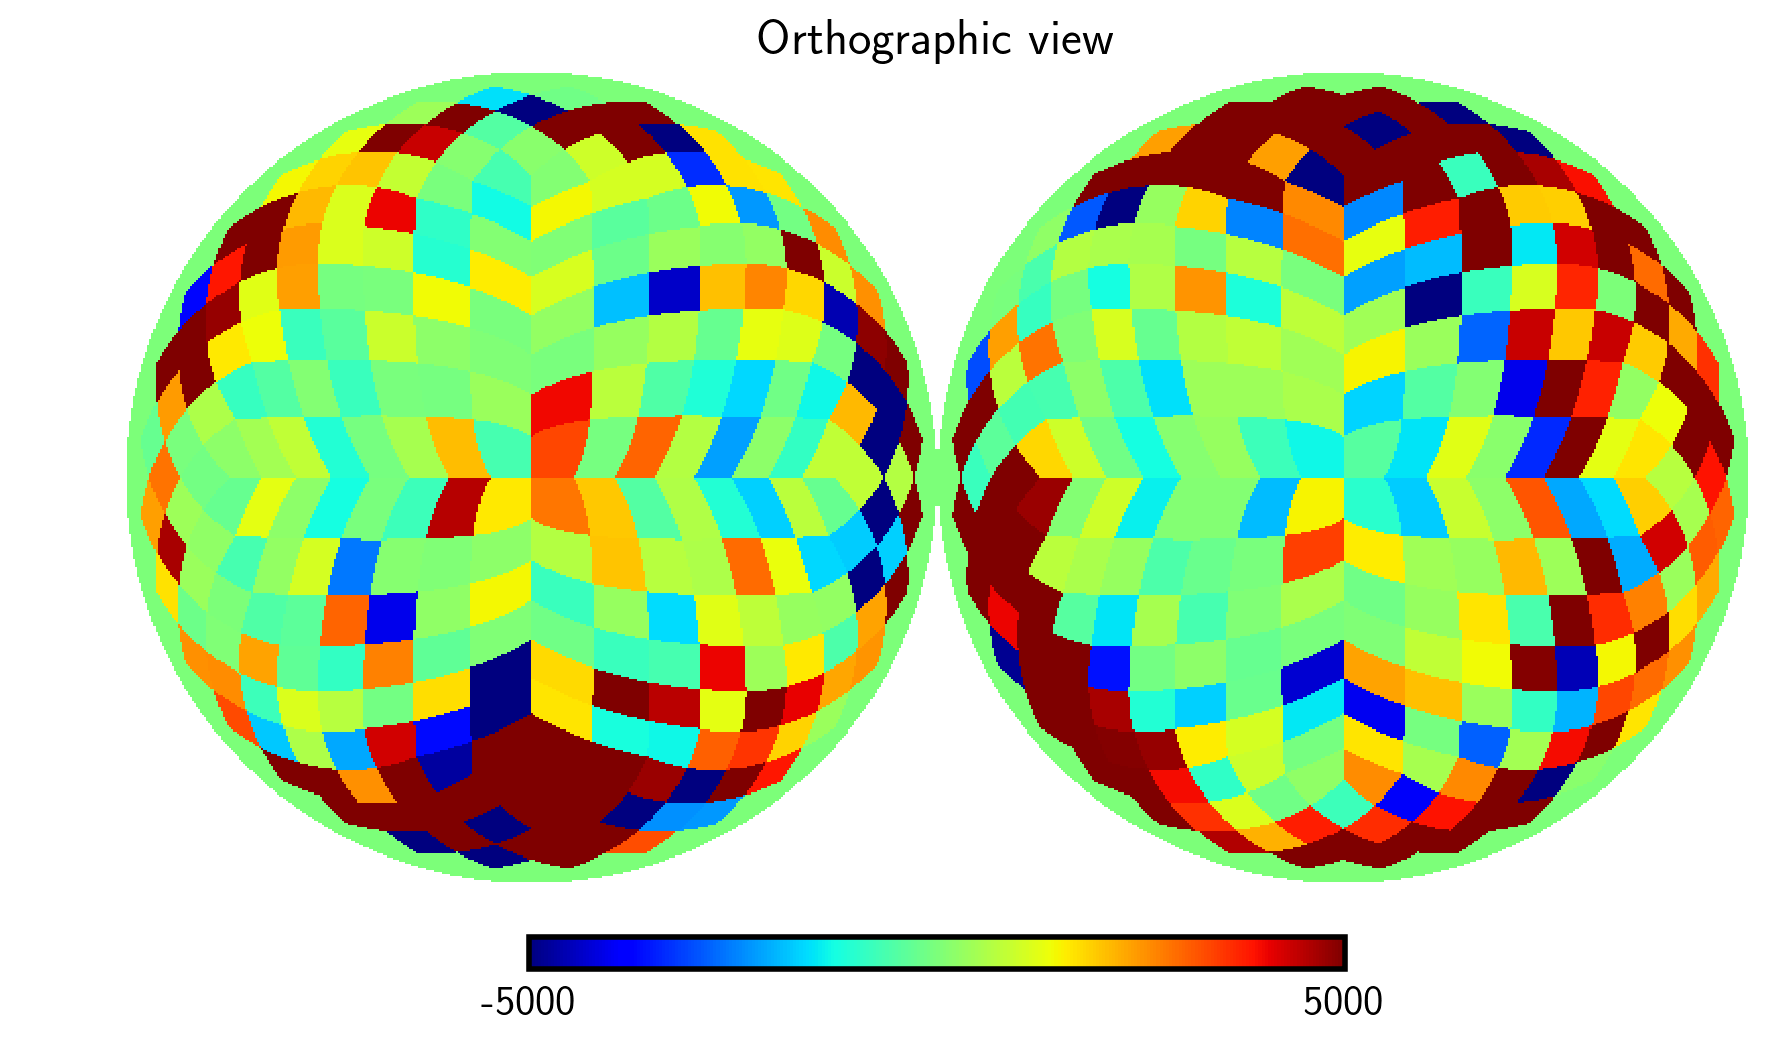

In [14]:
h.orthview(tetbpow[:,0],rot=(0,90),max=5000,min=-5000)

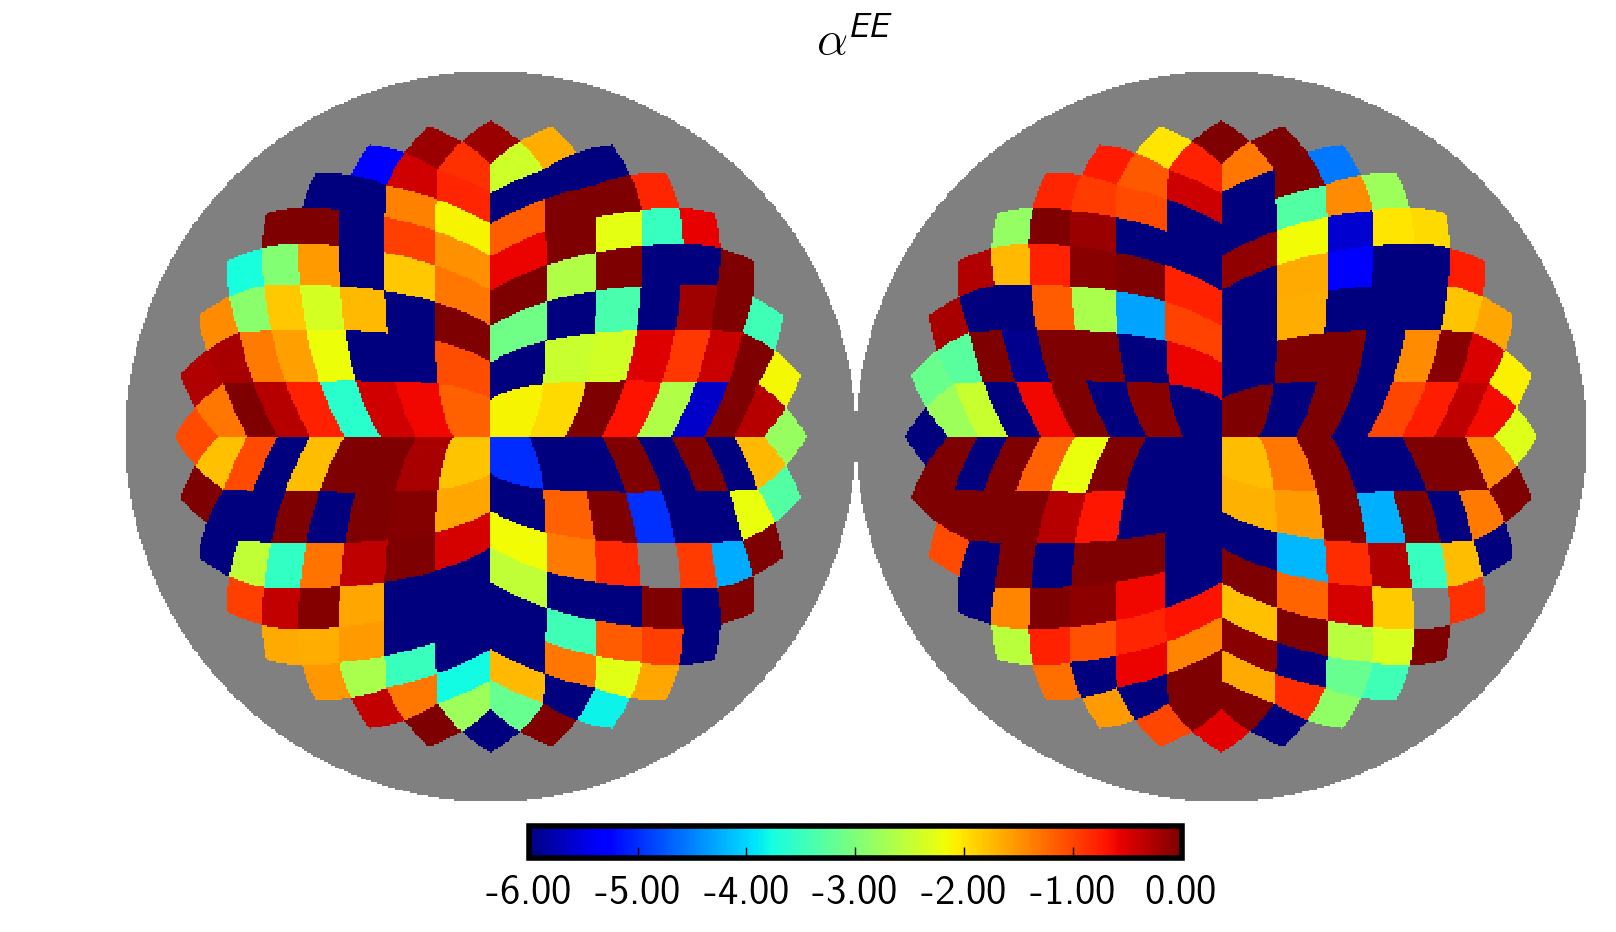

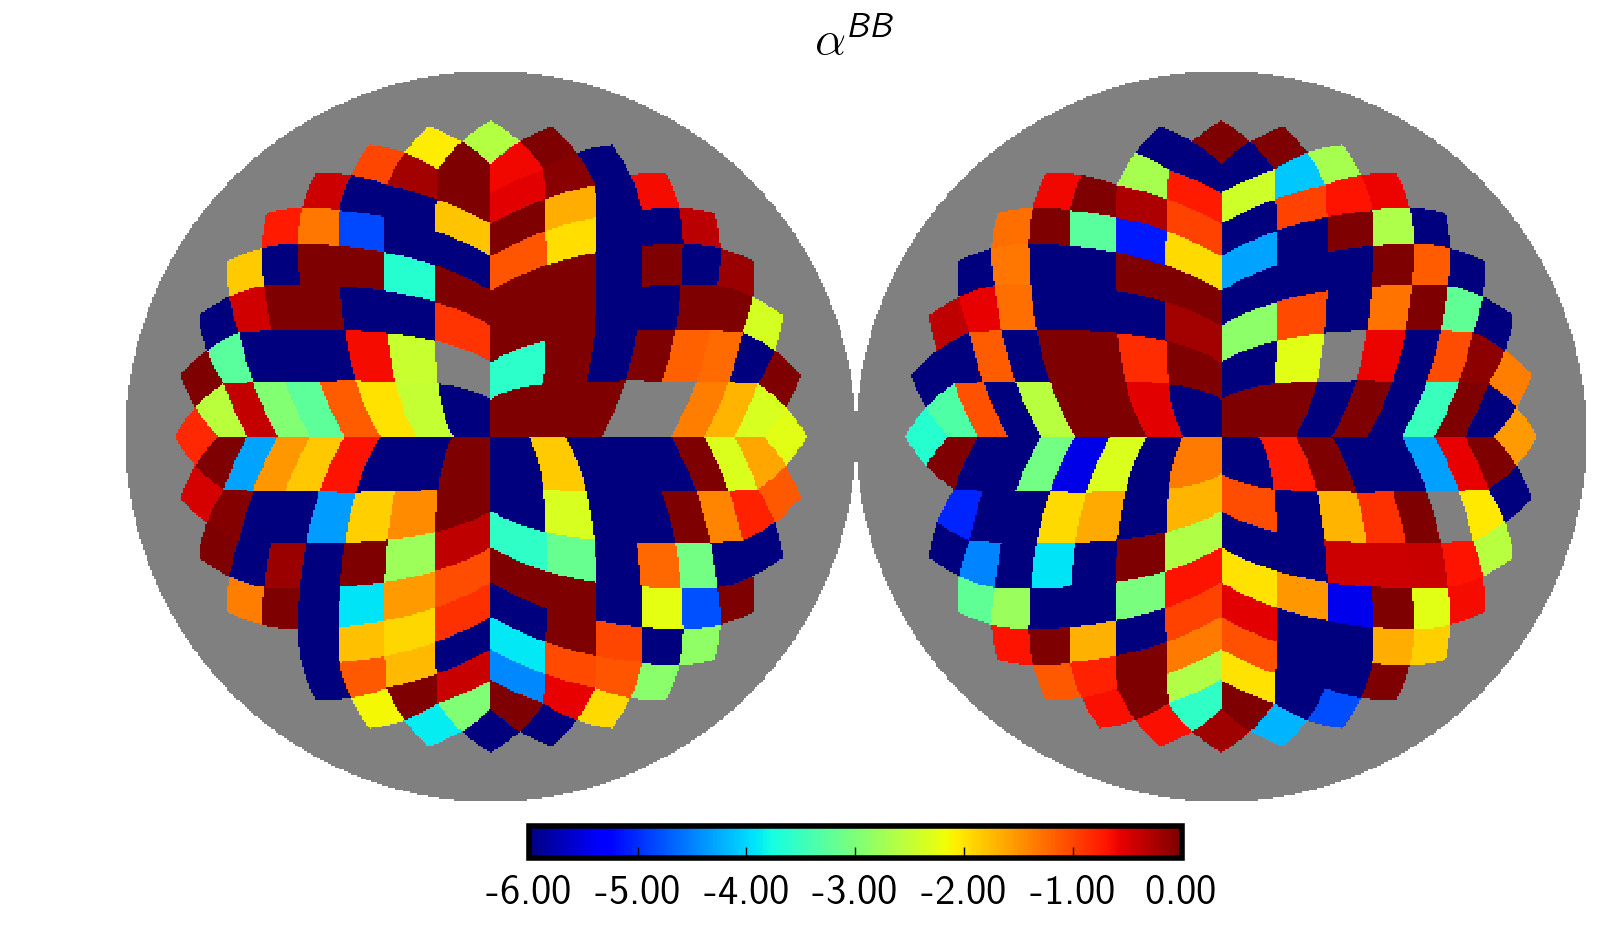

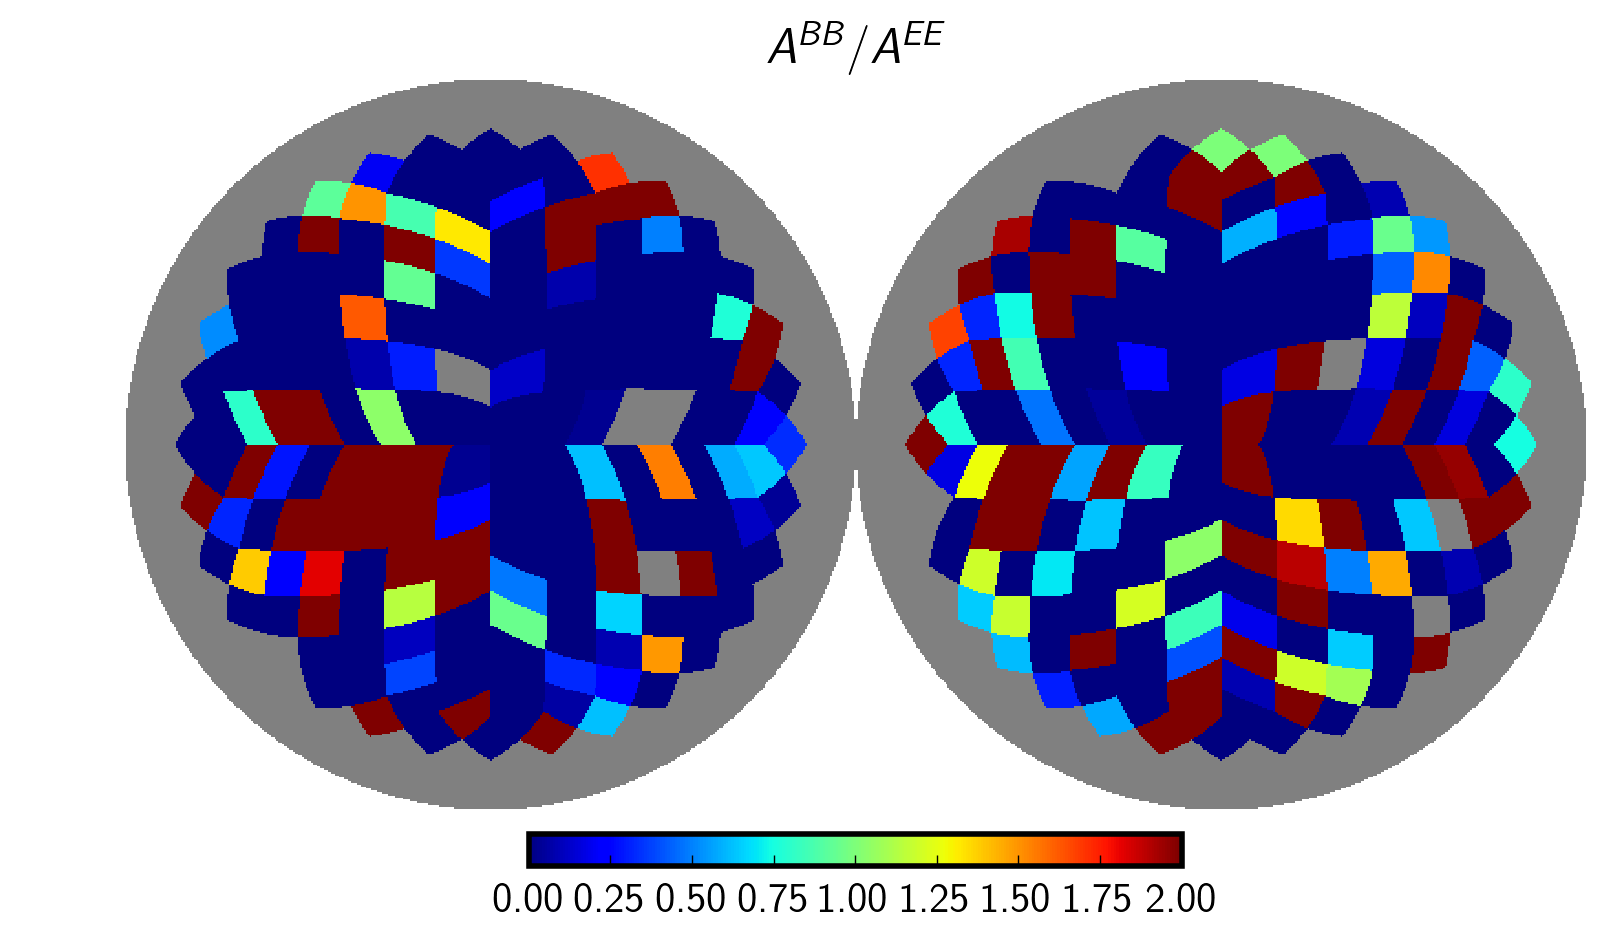

In [14]:
if makeplots:
    vmin=0 ; vmax=200
    h.orthview(fitee[:,0]*masknan,rot=(0,90),title=r"$A^{EE}$",min=vmin,max=vmax,cbar=None)
    fig = gcf() ; ax = gca() ; image = ax.get_images()[0]
    cmap = fig.colorbar(image,orientation="horizontal",shrink=0.4,pad=-0.05,ticks=linspace(vmin,vmax,8),format="%.0f")
    cmap.solids.set_edgecolor("face")
    figname=plot_results_path + "amp_ee" + ext
    savefig(figname,dpi=150,bbox_inches="tight")
    close()

    vmin=-6 ; vmax=0
    h.orthview(fitee[:,1]*masknan,rot=(0,90),title=r"$\alpha^{EE}$",min=vmin,max=vmax,cbar=None)
    fig = gcf() ; ax = gca() ; image = ax.get_images()[0]
    cmap = fig.colorbar(image,orientation="horizontal",shrink=0.4,pad=-0.05,ticks=linspace(vmin,vmax,7),format="%.2f")
    cmap.solids.set_edgecolor("face")
    figname=plot_results_path + "alpha_ee" + ext
    savefig(figname,dpi=150,bbox_inches="tight")
    close

    vmin=0 ; vmax=200
    h.orthview(fitbb[:,0]*masknan,rot=(0,90),title=r"$A^{BB}$",min=vmin,max=vmax,cbar=None)
    fig = gcf() ; ax = gca() ; image = ax.get_images()[0]
    cmap = fig.colorbar(image,orientation="horizontal",shrink=0.4,pad=-0.05,ticks=linspace(vmin,vmax,8),format="%.0f")
    cmap.solids.set_edgecolor("face")
    figname=plot_results_path + "amp_bb" + ext
    savefig(figname,dpi=150,bbox_inches="tight")
    close()

    vmin=-6 ; vmax=0
    h.orthview(fitbb[:,1]*masknan,rot=(0,90),title=r"$\alpha^{BB}$",min=vmin,max=vmax,cbar=None)
    fig = gcf() ; ax = gca() ; image = ax.get_images()[0]
    cmap = fig.colorbar(image,orientation="horizontal",shrink=0.4,pad=-0.05,ticks=linspace(vmin,vmax,7),format="%.2f")
    cmap.solids.set_edgecolor("face")
    figname=plot_results_path + "alpha_bb" + ext
    savefig(figname,dpi=150,bbox_inches="tight")
    close
    
    vmin=0 ; vmax=2
    h.orthview((fitbb[:,0]/fitee[:,0])*masknan,rot=(0,90),title=r"$A^{BB}/ A^{EE}$",min=vmin,max=vmax,cbar=None)
    fig = gcf() ; ax = gca() ; image = ax.get_images()[0]
    cmap = fig.colorbar(image,orientation="horizontal",shrink=0.4,pad=-0.05,ticks=linspace(vmin,vmax,9),format="%.2f")
    cmap.solids.set_edgecolor("face")
    figname=plot_results_path + "amp_ratio_b2e" + ext
    savefig(figname,dpi=150,bbox_inches="tight")
    close

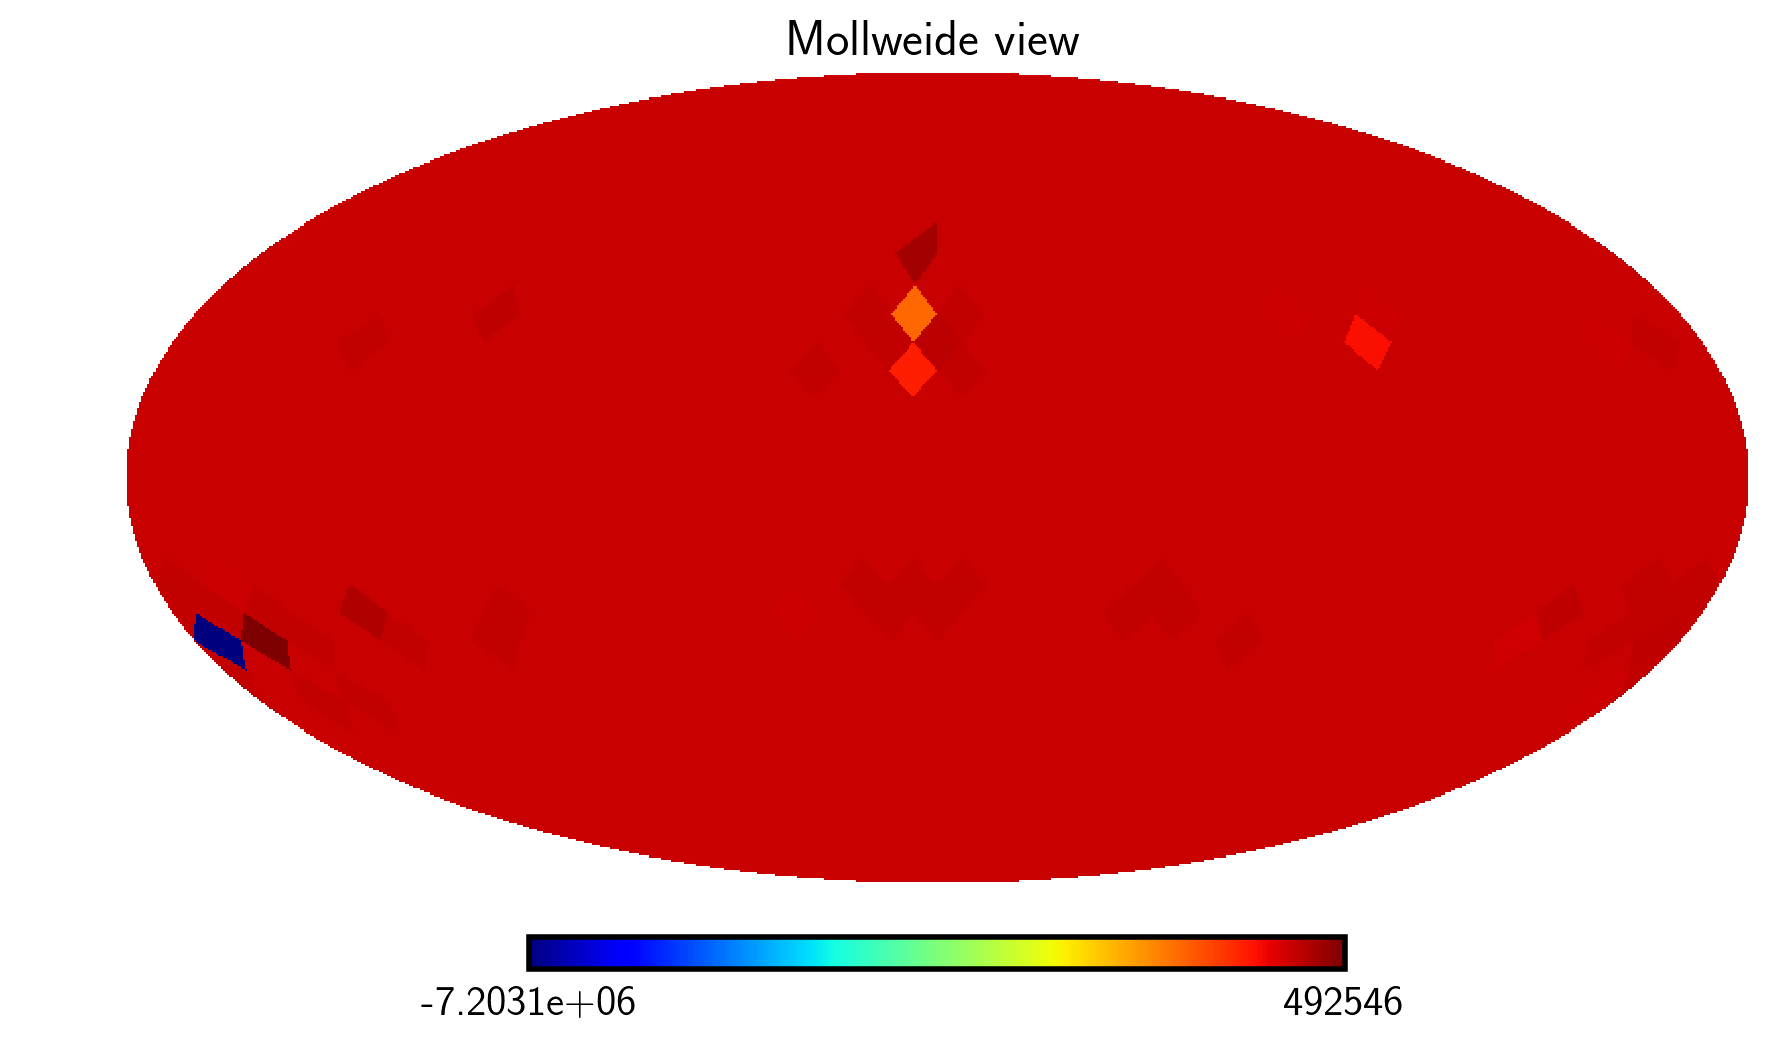

In [6]:
h.mollview(tetbpow[:,0])

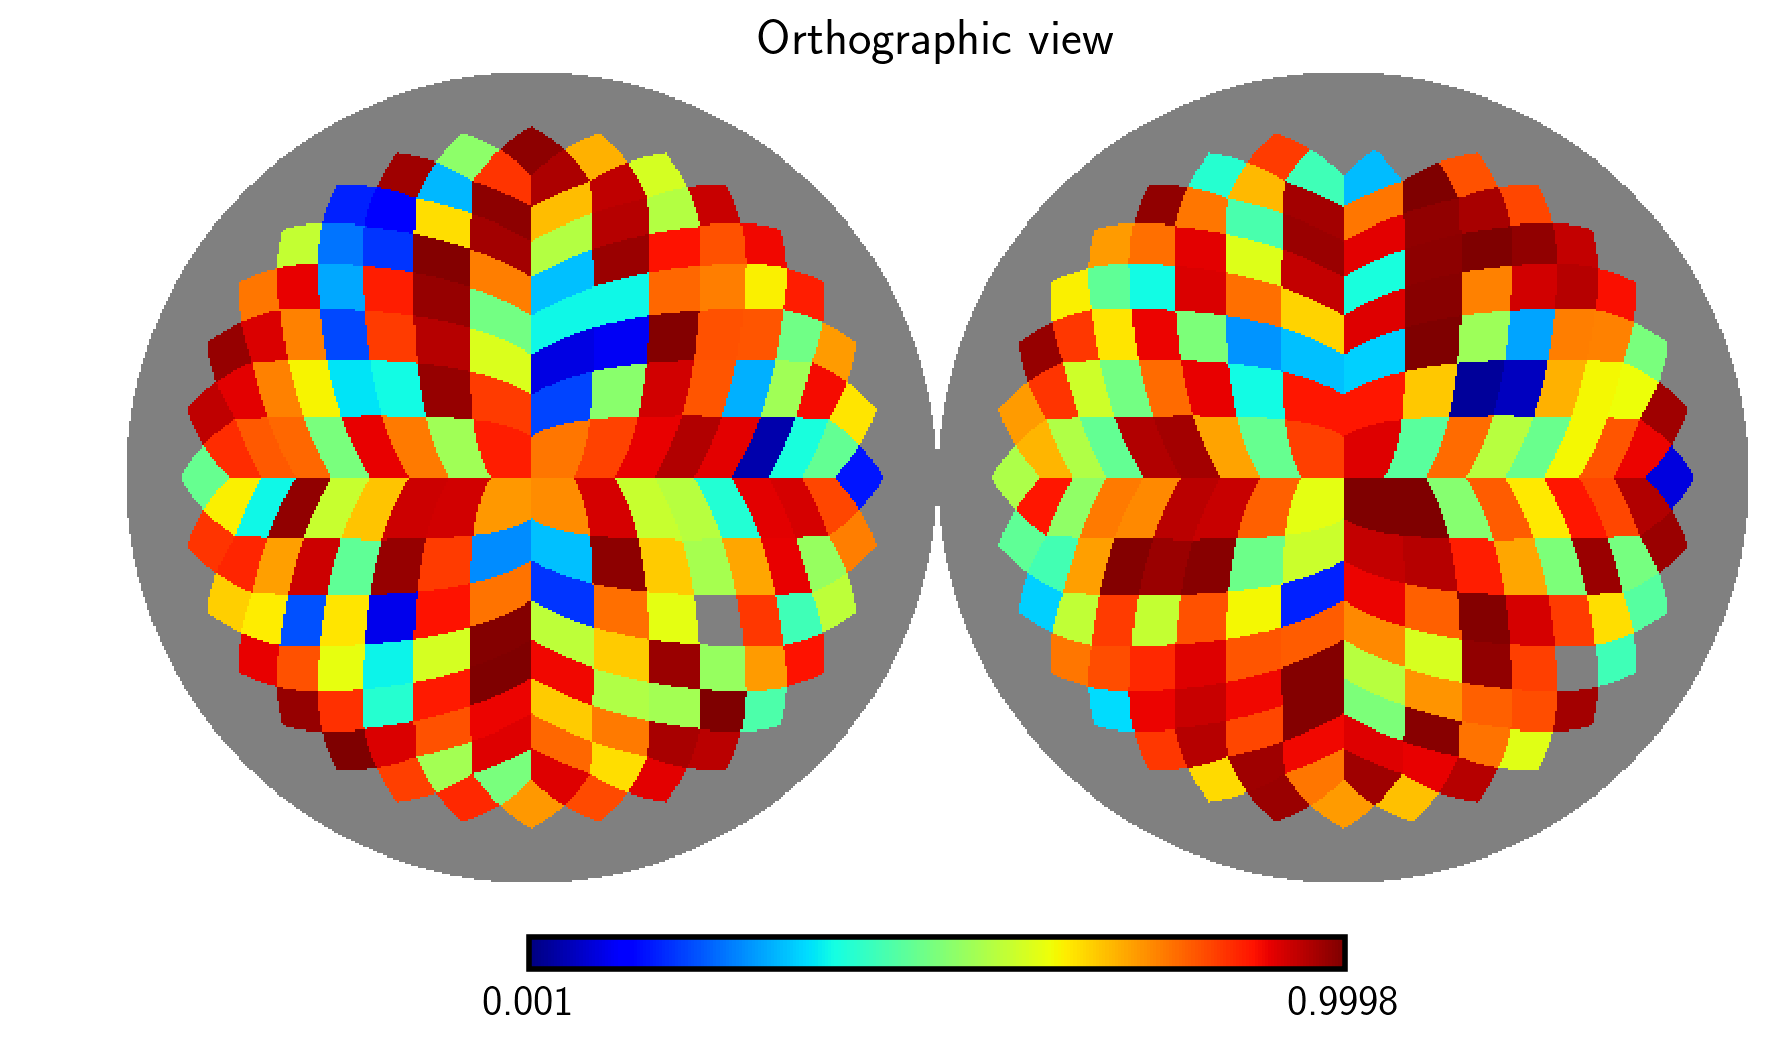

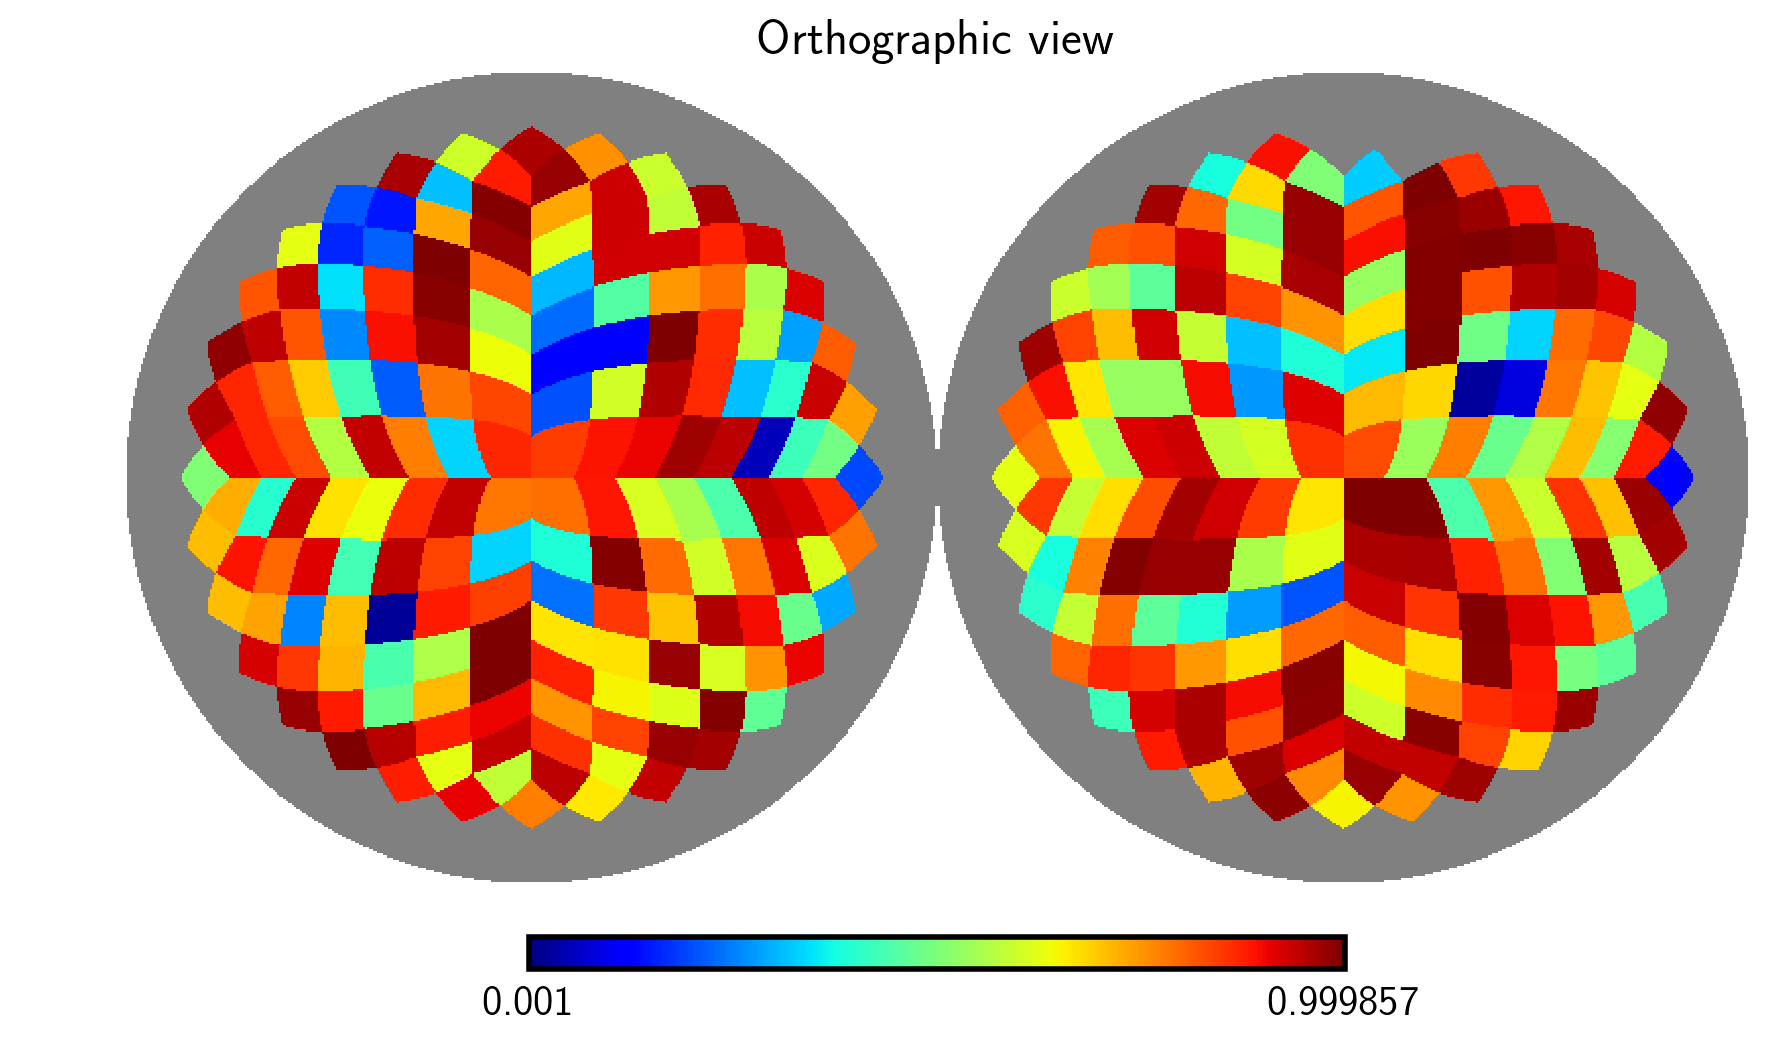

In [15]:
h.orthview(fitee_stat[:,2]*masknan,rot=(0,90),min=1e-3)
h.orthview(fitee_stat[:,5]*masknan,rot=(0,90),min=1e-3)

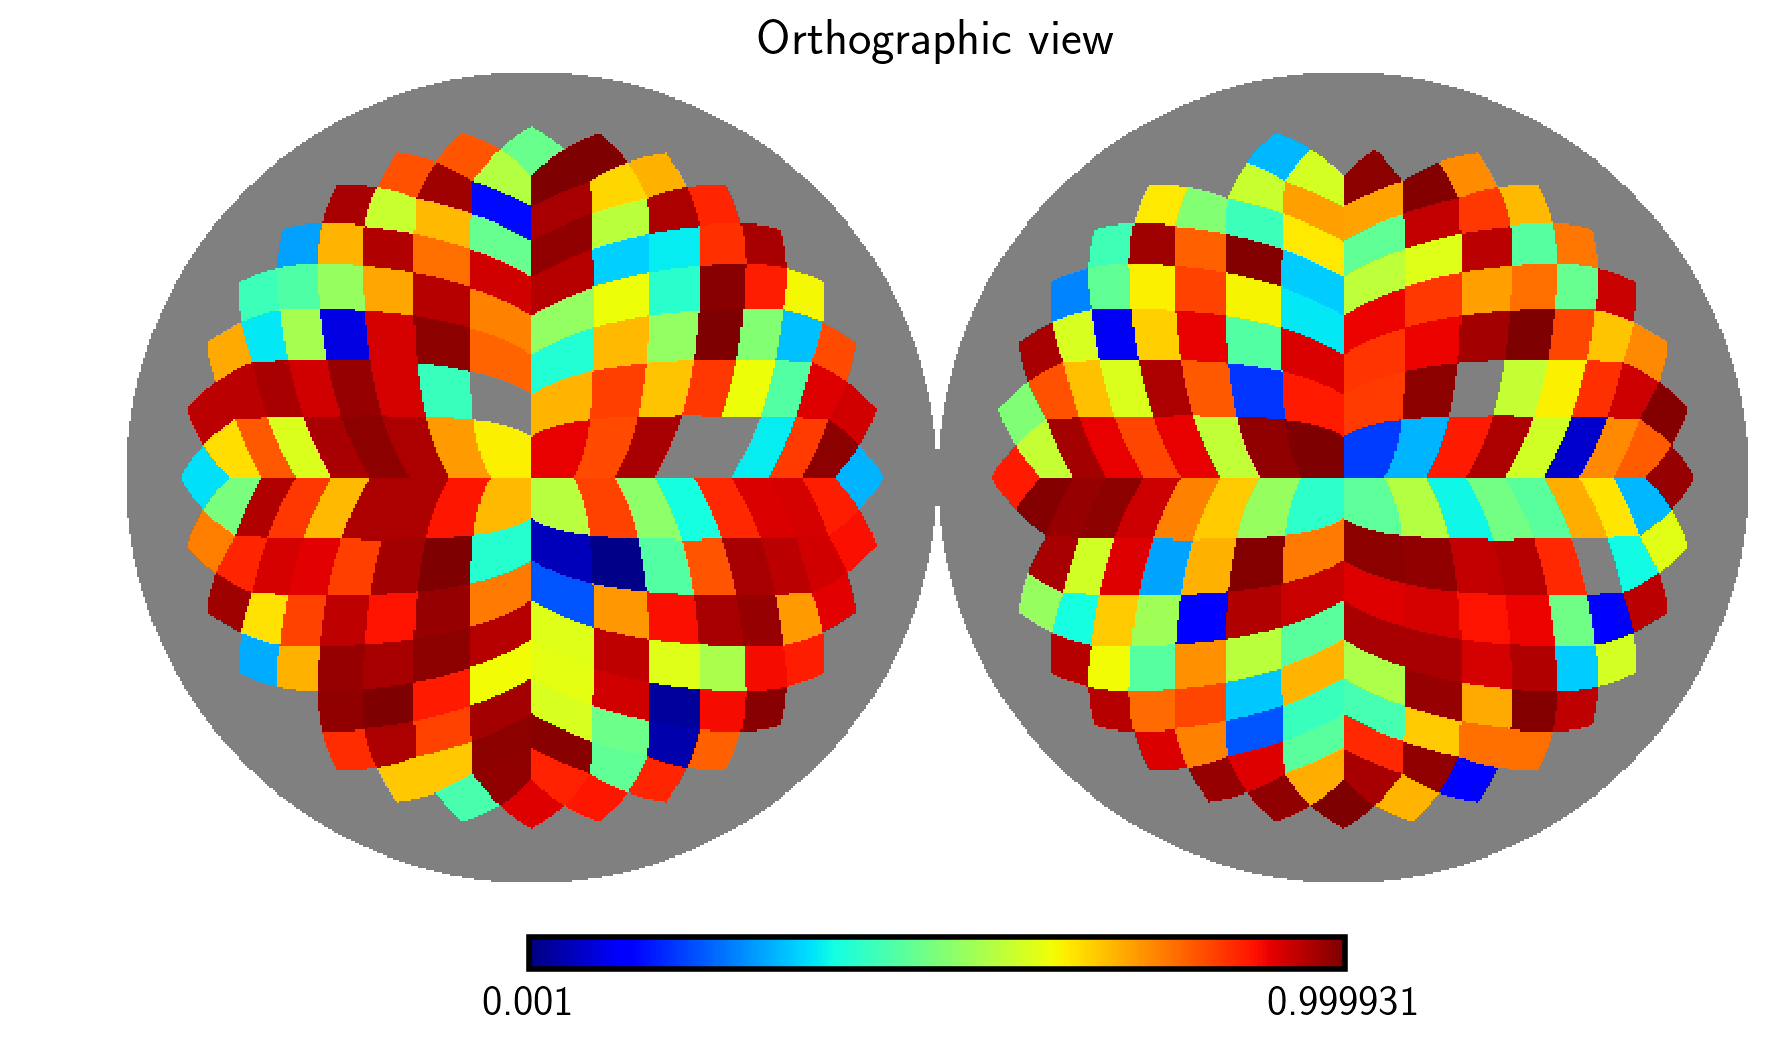

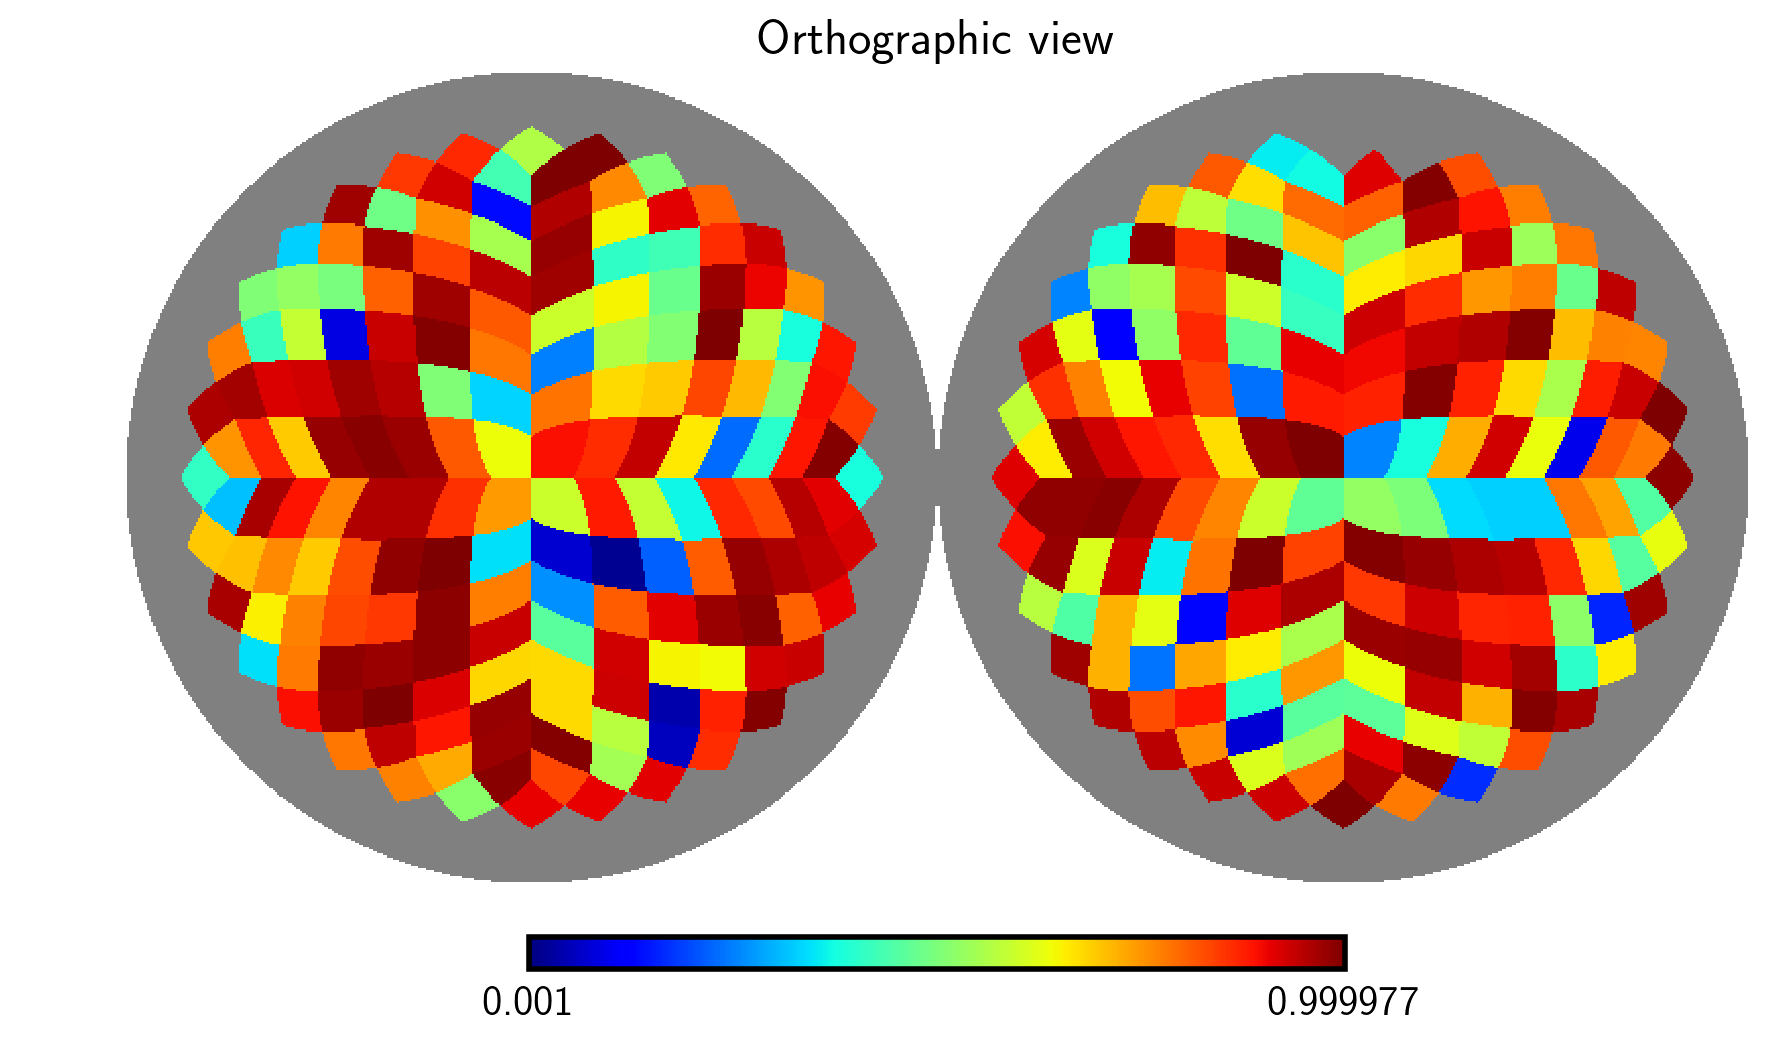

In [16]:
h.orthview(fitbb_stat[:,2]*masknan,rot=(0,90),min=1e-3)
h.orthview(fitbb_stat[:,5]*masknan,rot=(0,90),min=1e-3)